# X-AI applied to Generated Clusters with SHAP

### Load Data

In [14]:
# import packages
import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt 
import seaborn as sns

In [15]:
# load train and test data
train_data = pd.read_csv("dataset/task2/train_pts.csv")
test_data = pd.read_csv("dataset/task2/test_pts.csv")
print("#samples in train = ", len(train_data))
print("#samples in test  = ", len(test_data))

#samples in train =  1125
#samples in test  =  375


### Preprocessing

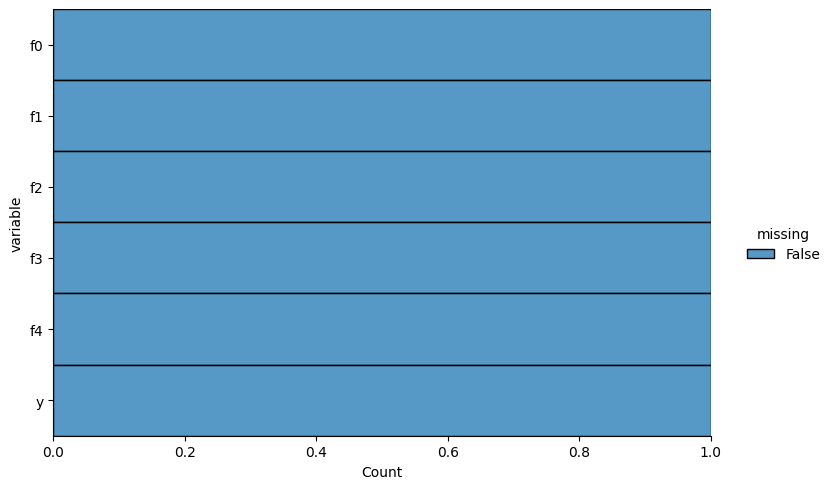

In [16]:
# check missing data
sns.displot(
    data = train_data.isna().melt(value_name="missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 1.5
)

plt.show()

In [17]:
# visualize data
train_data.head()

,f0,f1,f2,f3,f4,y
0,1.7005,1.3531,1.2401,2.0728,1.6070,1.6064
1,0.7965,0.7256,0.5263,0.7339,0.8046,0.7234
2,2.8373,2.2479,3.0573,2.9302,2.8407,2.3597
3,3.0394,2.8822,2.4963,2.6470,2.7702,2.8105
4,2.0894,1.2275,1.9977,1.8091,1.1260,1.8924


In [18]:
# split independent variable (X) and dependent (Y) for train and test set
x_train = train_data.drop(columns = ["y"])
y_train = train_data["y"]
x_test = test_data.drop(columns = ["y"])
y_test = test_data["y"]

In [19]:
# extract feature names
feature_names = x_train.columns 
print("features: ", feature_names)

features:  Index(['f0', 'f1', 'f2', 'f3', 'f4'], dtype='object')


Functions to save and load models

In [20]:
import pickle

# function to save model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [21]:
# function to load model
def load_model(filename):
    with open(filename, "rb") as file:
        return pickle.load(file)

### Training with LightGBM Regressor

Training with hyperparameter tuning

In [13]:
# import packages
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV 

# define grid hyperparameters 
lgbm_params = {
    "max_depth": range(8, 32, 8),
    "num_leaves": range(30, 80, 10),
    "learning_rate": [1e-3, 0.01, 0.05, 0.1],
    "bagging_fraction": [0.7, 0.8, 0.9]
}

In [14]:
# define the LightGBM regressor
lgbm_grid = GridSearchCV(estimator = lgbm.LGBMRegressor(),  # regressor model
                         param_grid = lgbm_params,  # dict of hyperparamters
                         cv = 5,    # 5-fold cross-validation
                         scoring = "r2",    # r2 metric for evaluation
                         verbose = False,
                         n_jobs = -1    # all processors running in parallel
                    )
# fit the model
lgbm_grid.fit(x_train, y_train)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 5
[LightGBM] [Info] Start training from score 1.561047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'bagging_fraction': [0.7, 0.8, 0.9],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1],
                         'max_depth': range(8, 32, 8),
                         'num_leaves': range(30, 80, 10)},
             scoring='r2', verbose=False)

In [15]:
# take the best model
best_lgbm = lgbm_grid.best_estimator_
best_lgbm_params = lgbm_grid.best_params_
best_lgbm_score = lgbm_grid.best_score_

In [16]:
# check the best model
print("best xgboost model parameters: ", best_lgbm_params)
# check the training score
print("best train-score: ", best_lgbm_score)

best xgboost model parameters:  {'bagging_fraction': 0.7, 'learning_rate': 0.1, 'max_depth': 24, 'num_leaves': 30}
best train-score:  0.9996705687288113


In [17]:
# save best xgboost model
save_model(best_lgbm, "models/lgbm_clusters_gen_v1.pkl")

Inference with LightGBM

In [22]:
# recover the model
lgbm_model = load_model("models/lgbm_clusters_gen_v1.pkl")

In [23]:
# predict values
y_pred = lgbm_model.predict(x_test)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


In [24]:
# evaluate model
from sklearn.metrics import r2_score

lgbm_r2 = r2_score(y_test, y_pred)
print("R^2 test score: ", lgbm_r2)

R^2 test score:  0.9997009173518074


### Explainable AI

In [25]:
import shap

# apply tree explainer
explainer = shap.TreeExplainer(lgbm_model, x_test)
shap_values = explainer(x_test)

In [26]:
# save shap values
np.savetxt("shap_values/shap_lgbm.csv", shap_values.values,
           header = ",".join(feature_names), delimiter = ",")

#### Global Explanations

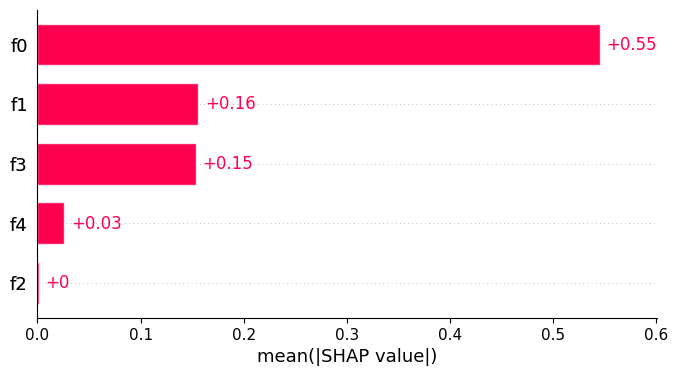

In [23]:
# global explanations using feature importance bar plots
shap.plots.bar(shap_values)

##### Interpretation: Global explanations using feature importante plots  
SHAP values explain the average contribution of each feature to the model predictions. The length of the bar indicates the average magnitude of a feature's impact on model predictions, and color indicates if impact is positive (red) or negative (blue).
- The feature f0 has the highest average SHAP value, which means it generally has the strongest influence in the model's predictions.  

- The influence of f1 and f3 are next, with an average SHAP value smaller than f0, but still significant.  

- f4 have a smaller influence, but still contribute to the model.  

- f2 has the smallest average SHAP value, indicating it has the weakest influence on the model predictions.  

- The numerical labels (e.g., +0.55, +0.16, etc.) represent the specific average SHAP values, which can be understood as the average contribution of the feature to the prediction outcome. These values may be positive or negative, representing the positive or negative impact of an increase in the feature value on the prediction outcome.

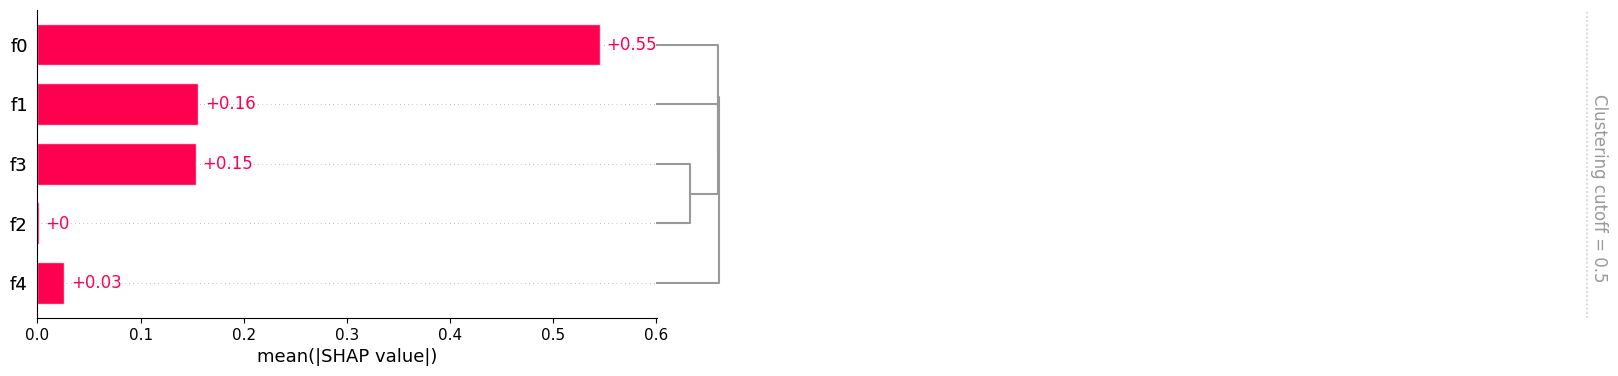

In [24]:
# bar plots with hierarchical clustering among the features
clustering = shap.utils.hclust(x_test, y_test)
shap.plots.bar(shap_values, clustering = clustering, clustering_cutoff = 0.5)

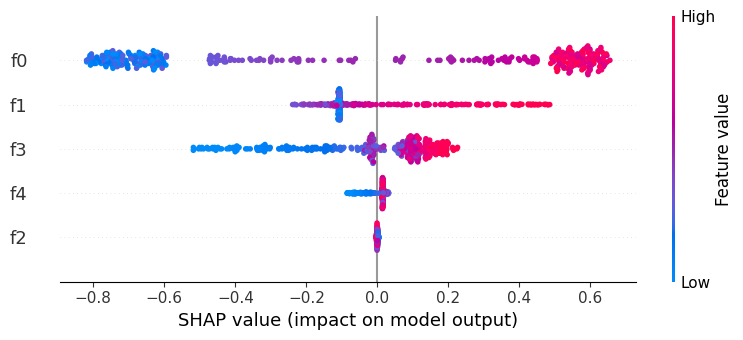

In [25]:
# global explainability with summary plots
shap.summary_plot(shap_values, x_test, feature_names)

##### Interpretation: Global explanations using summary plots
The image shows a SHAP summary plot, which provides a global view of the impact of the features on the model output. Each point on the summary plot represents a SHAP value for a feature and a specific data point. The position on the x-axis indicates the SHAP value (impact on model output), while the color represents the value of the feature from low (blue) to high (red).  

- Feature f0 has a wide spread of SHAP values, indicating a variable impact on the model output. The cluster of points to the far right suggests instances where f0 has a high positive impact on the model output, and the points far left has a low negative impact

- Feature f1 also shows a variable impact but with a slight skew towards positive SHAP values, suggesting that, overall, it tends to positively influence the model's predictions.  

- Feature f3 in several points have median positive impact in predictions, in some other points low negative impact

- Feature f4 shows a very low negative impact at most points

- Feature f2 has the least spread of SHAP values and is concentrated around zero, suggesting it has the smallest impact on the model output across the data points.  

The plot indicates the importance and the direction of the impact each feature has on the model's predictions. Features that have a mix of high and low SHAP values (both positive and negative) across different data points indicate interactions with other features or non-linear effects within the model.

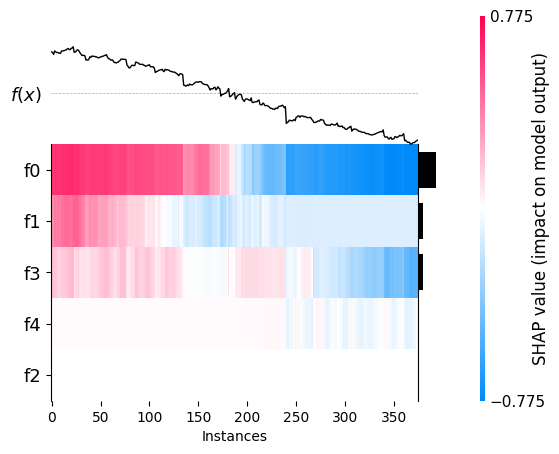

In [26]:
# global explainability with heat maps
shap.plots.heatmap(shap_values, max_display = 5)

##### Interpretation: Global explanations with heat maps  
- Impact of features on model prediction:   
Each row displays the SHAP values of the corresponding feature, with the intensity of the color indicating the size of the feature value's impact on the model output. The deeper the color, the greater the impact. Red represents a positive impact, while blue indicates a negative impact.  
  
- Magnitude of feature values:   
The color gradient from blue to red represents feature values from low to high. This suggests that we can identify which feature values play a significant role in the model's predictions.  
  
- Comparison between different samples:   
Horizontally, the variation in the impact of features across different samples can be observed. For some samples, a specific feature may have a substantial positive impact, while for others, the same feature may have a negative or smaller impact.  
  
- Distribution of model predictions:  
The line graph at the top of the image shows how the model's output values (predictions) vary with the samples. This helps us understand the distribution of model outputs across the entire dataset.  
  
- Features with the greatest impact:  
Based on the color bar and intensity, we can infer which features have the greatest impact on the model's output. In this particular heatmap, the f0 feature appears to have a larger positive impact across many samples, while the f2 feature seems to have the least impact on model output.  
  
- Consistency of feature impact:  
Certain features, like f0 and f1, exhibit a similar direction of impact (positive or negative) across most samples, while other features may have varying directions of impact across different samples.

In [27]:
# global explainability with Partial Dependency Plots
explainer2 = shap.TreeExplainer(lgbm_model)
shap_values2 = explainer2.shap_values(x_test)

Partial dependency plot (PDP) for f0


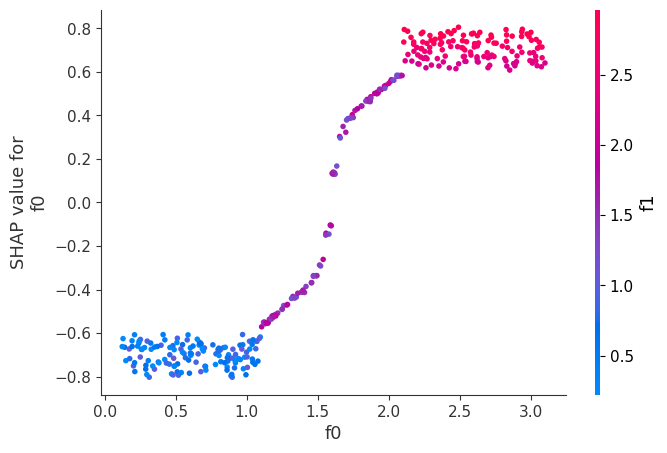

Partial dependency plot (PDP) for f1


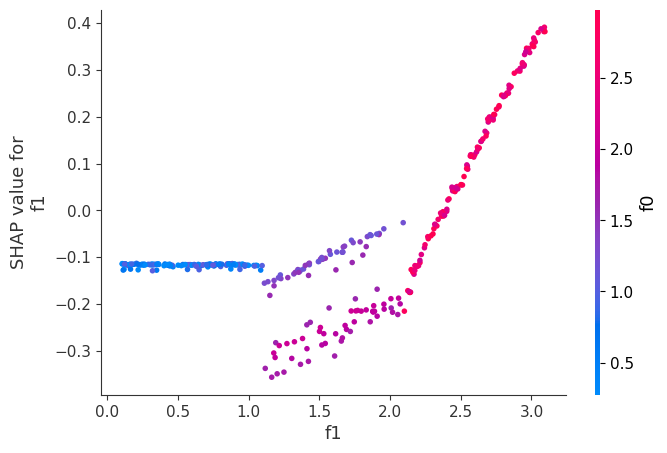

Partial dependency plot (PDP) for f2


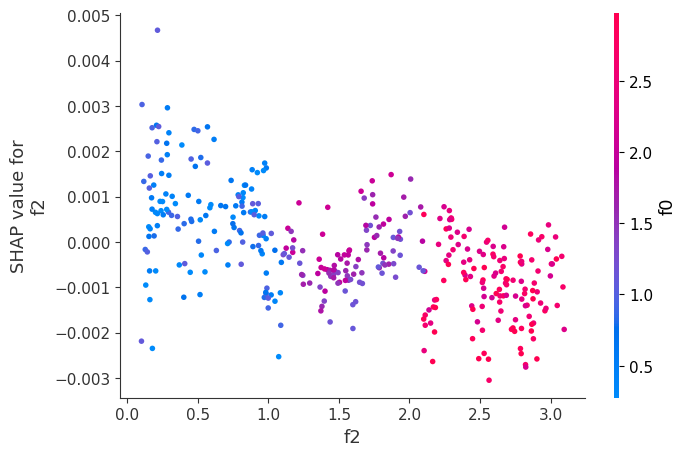

Partial dependency plot (PDP) for f3


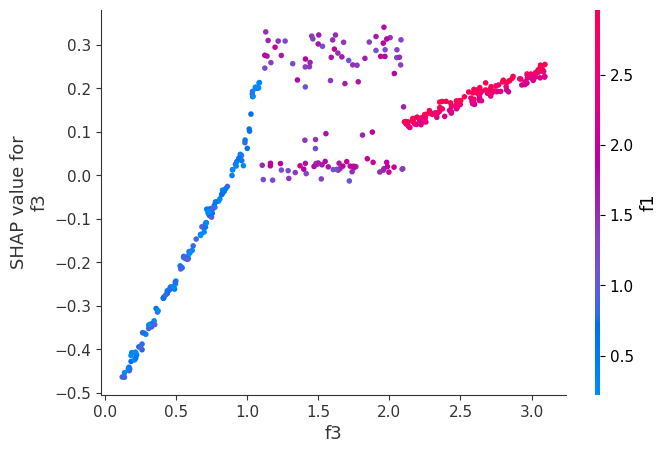

Partial dependency plot (PDP) for f4


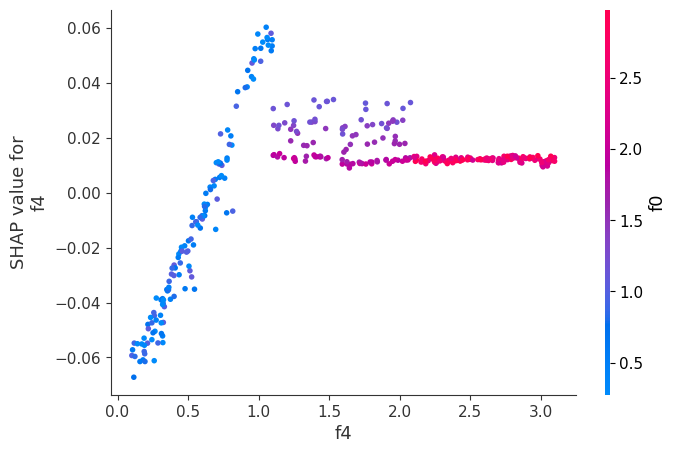

In [28]:
for col in feature_names.values:
    print(f"Partial dependency plot (PDP) for {col}")
    shap.dependence_plot(col, shap_values2, x_test, feature_names = feature_names)

##### Interpretation: Global explanations with PDP  
The series of plots are Partial Dependence Plots (PDPs) generated using SHAP values. These plots are used to show the relationship between a particular feature and the impact it has on the predictive model’s output. Here’s an analysis of each plot:

- **f0**: The SHAP values for f0 increase significantly as the value of f0 increases. There seems to be a threshold around the value of f0 where the impact on the model output changes from negative (or no impact) to a positive impact. This suggests that higher values of f0 have a strong positive effect on the model's prediction.
- **f1**: This plot indicates a clear positive correlation between the feature value and its SHAP value, meaning as f1 increases, its impact on the model's output also increases. There is a relatively smooth gradient, suggesting a consistent and predictable relationship.
- **f2**: For f2, the SHAP values scatter is difuse and is not possible define some increse or decrease relationship between f2 variable and its corresponded shap values.
- **f3**: Similar to f1, f3 shows a positive correlation with the SHAP values. The impact on the model's output increases as the value of f3 increases, indicating that f3 is an important feature for the model's predictions.
- **f4**: The SHAP values for f4 the relationship here is less clear, suggesting that the influence of f4 on the model output may depend on interactions with other features or is not linear.
- These PDPs are powerful because they can show whether the relationship between the target and the features is linear, monotonic, or more complex. For example, if SHAP values for a feature increase as the feature values increase, this indicates a positive correlation, which can be linear or non-linear. If SHAP values decrease, it indicates a negative correlation. If there is no clear trend or if there is a lot of variability in SHAP values at different feature values, this might suggest a non-monotonic relationship or interaction effects with other features.

#### Local Explanations

In [29]:
# define explainer
local_explainer = shap.TreeExplainer(lgbm_model)
local_shap_values = local_explainer.shap_values(x_test)

In [30]:
# instance to explain
instance_idx = 100

In [31]:
# local explainability with force plots
shap.initjs()
shap.force_plot(local_explainer.expected_value, local_shap_values[instance_idx], 
                features = x_test.iloc[instance_idx])

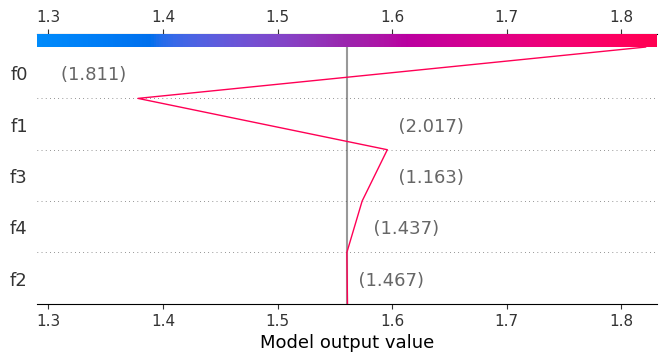

In [32]:
# local explainability with decision plots
shap.decision_plot(local_explainer.expected_value, local_shap_values[instance_idx], 
                   features = x_test.iloc[instance_idx])

##### Interpretation: Local explanations with Decision plots
- Base Value: The plot starts with the base value, which is the average prediction for the dataset (or the expected value of the model output). This is represented by where the red line starts on the y-axis.

- Feature Contributions: Each feature contributes either positively or negatively towards the final prediction. This is shown by the red line moving up or down as it progresses from left to right.

- Final Prediction: The end of the red line indicates the final prediction for the instance. This is the sum of the base value and all the individual SHAP values for the features.

- Feature Impact: The features are listed on the y-axis, with the starting point of each feature’s contribution shown on the line. The length of the line horizontally associated with each feature represents the magnitude of that feature’s impact. If the line extends to the right, it means the feature is pushing the prediction higher than the base value. If it extends to the left, it is pushing the prediction lower.

- Numerical SHAP Values: The numbers in parentheses next to the feature names represent the actual SHAP values for this instance. They quantify the impact of each feature on the prediction.

In conclusion, in  the case of a local explanation with decision plots:  

- f1 has the largest positive impact, pushing the prediction higher by approximately 2.017 units.
- f0 also has a positive impact but less so than f1.
- f3 and f4 have a negative impact, slightly lowering the prediction.
- f2 has the least impact on the prediction among the features shown.

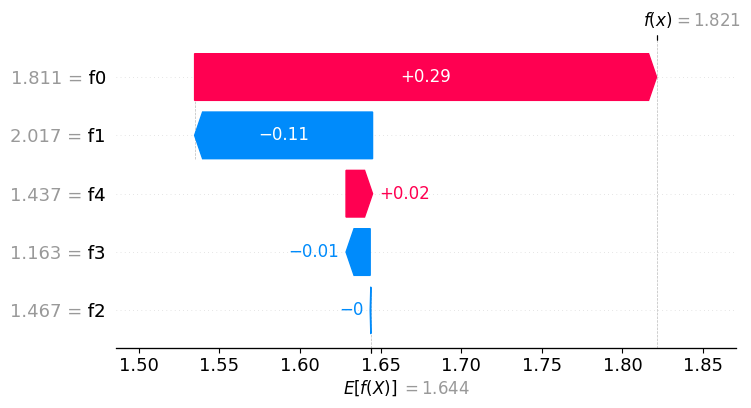

In [33]:
# local explainability with waterfall plots
shap.initjs()
shap.waterfall_plot(shap_values[instance_idx])

##### Interpretation: Local explanations with waterfall plots
- The plot starts with the base value, which is the average prediction of the model over the dataset (E[f(X)]), often referred to as the expected value. In this case, it's 1.644.

- Each bar represents the contribution of a feature to the prediction. The size and direction of the bar indicate how much and in which direction each feature is influencing the prediction.

- Red bars represent features that push the prediction higher (positive impact), and blue bars represent features that push the prediction lower (negative impact).
- The length of each bar shows the magnitude of each feature's contribution. For example, f0 with a value of 1.811 has a large positive effect on the model output, increasing it by 0.29 from the base value.

- The features are ordered from the bottom to the top in terms of their impact on the prediction, starting from the base value and cumulatively adding the contribution of each feature.

- At the top of the plot, you arrive at the actual prediction (f(x)), which in this case is 1.813. This is the sum of the base value and all the individual SHAP values.

- In this specific instance, f0 is the feature with the largest positive contribution to the model's prediction, increasing the expected output significantly. f1 slightly decreases the prediction, whereas f4 and f3 have very small positive contributions. f2's contribution is almost not significant

Clusterization of SHAP values

In [ ]:
# recover shap data
shap_data = pd.read_csv("shap_values/shap_lgbm.csv")
shap_data.head()

,f0,f1,f2,f3,f4
0,-0.728495,-0.107189,0.002131,-0.331956,0.002930
1,0.439006,-0.182840,0.000668,-0.018786,0.012259
2,0.524516,-0.014060,-0.001995,0.173125,0.014169
3,0.646981,0.438665,-0.001187,0.225766,0.016420
4,-0.662612,-0.106329,0.001249,-0.134823,-0.031054


According X-AI visualizations, we concluded that features **f0**, **f1** and **f3** are the most relevant.  
Thus, apply dimensionality reduction before clustering 

In [ ]:
relevant_features = ['f0', 'f1', 'f3']
shap_rel = shap_data[relevant_features]
shap_rel.head()

,f0,f1,f3
0,-0.728495,-0.107189,-0.331956
1,0.439006,-0.182840,-0.018786
2,0.524516,-0.014060,0.173125
3,0.646981,0.438665,0.225766
4,-0.662612,-0.106329,-0.134823


In [ ]:
# define K-means clustering algorithm
from sklearn.cluster import KMeans 

kmeans = KMeans(n_clusters = 3, random_state = 0)
kmeans.fit(shap_rel)

KMeans(n_clusters=3, random_state=0)

In [66]:
# Function to plot clusters in 3D
from mpl_toolkits.mplot3d import Axes3D

def plot_cluster_shap_3d(shap_data, model):
    cluster_labels = model.labels_
    cluster_centers = model.cluster_centers_
    feature_x = 0; feature_y = 1; feature_z = 2

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(shap_data.iloc[:, feature_x], shap_data.iloc[:, feature_y], shap_data.iloc[:, feature_z], c=cluster_labels, cmap='viridis')
    ax.scatter(cluster_centers[:, feature_x], cluster_centers[:, feature_y], cluster_centers[:, feature_z],
               marker='x', c='red', s=200, label='Cluster Centers')

    ax.set_xlabel(f'SHAP f{feature_x}')
    ax.set_ylabel(f'SHAP f{feature_y}')
    ax.set_zlabel(f'SHAP f{feature_z}')
    ax.set_title('KMeans Clustering of SHAP Values')
    plt.show()

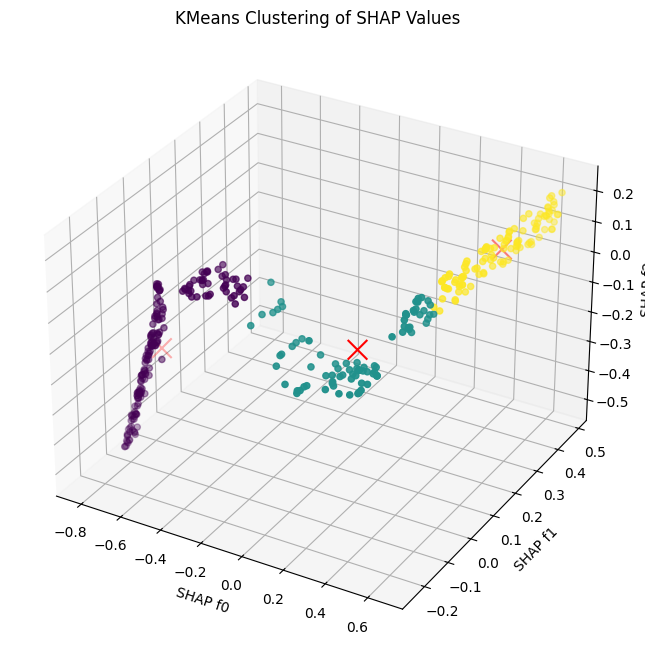

In [68]:
plot_cluster_shap_3d(shap_rel, kmeans)